# Covid-19 Global Forecast 

![](https://es.cochrane.org/sites/es.cochrane.org/files/public/uploads/Pages/evi-covid-19-page-2.jpg) 

Este es un desafío de Kaggle que ya está cerrado al momento en que lo estoy realizando, pero decidí hacerlo con fines de aprendizaje.
El desafío consiste en estimar casos confirmados y fallecimientos entre el 15 de abril y el 14 de mayo por región (país). Pero además de lo anterior también se busca identificar factores que podrían afectar la forma en que evoluciona el virus.
Como no participaré del concurso (ya estaba cerrado cuando comencé este desafío), no me adheriré totalmente a las reglas como formatos de entrega o aspectos formales.

Nota: Este análisis se realiza con fines de aprendizaje pero si encontrara algo que pudiera ser de utilidad para la comunidad científica lo compartiría de inmediato, todo lo hago dentro de un marco de respeto pues sé que las personas no son cifras, el que acá se utilicen cifras es solo para poder realizar el análisis. Aunque esto quizás no lo lea nadie, envío fuerza a las personas que están enfermas en este momento con Covid-19 y a sus familiares y amigos, y espero que tengan consuelo quienes han perdido a sus seres queridos.

### Visión general de los datasets 

In [1]:
#Análisis exploratorio de los datasets del desafío
import pandas as pd
import numpy as np

submission = pd.read_csv('data/submission.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [2]:
#train.csv - datos de entrenamiento
#test.csv - las fechas para predecir; hay 1 semana de superposición con los datos de entrenamiento para la
            #tabla de clasificación pública inicial. 
#submission.csv - un ejemplo de envío en el formato correcto; las predicciones deben ser acumulativas

#Imprimimos los dataset

display(submission.head(10))
display(train.head(12))
display(test.head(10))

,ForecastId,ConfirmedCases,Fatalities
0,1,1,1
1,2,1,1
2,3,1,1
3,4,1,1
4,5,1,1
5,6,1,1
6,7,1,1
7,8,1,1
8,9,1,1
9,10,1,1


,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0
5,6,NaN,Afghanistan,2020-01-27,0.0,0.0
6,7,NaN,Afghanistan,2020-01-28,0.0,0.0
7,8,NaN,Afghanistan,2020-01-29,0.0,0.0
8,9,NaN,Afghanistan,2020-01-30,0.0,0.0
9,10,NaN,Afghanistan,2020-01-31,0.0,0.0


,ForecastId,Province_State,Country_Region,Date
0,1,NaN,Afghanistan,2020-04-02
1,2,NaN,Afghanistan,2020-04-03
2,3,NaN,Afghanistan,2020-04-04
3,4,NaN,Afghanistan,2020-04-05
4,5,NaN,Afghanistan,2020-04-06
5,6,NaN,Afghanistan,2020-04-07
6,7,NaN,Afghanistan,2020-04-08
7,8,NaN,Afghanistan,2020-04-09
8,9,NaN,Afghanistan,2020-04-10
9,10,NaN,Afghanistan,2020-04-11


In [3]:
display(train.describe())
display(test.describe())

,Id,ConfirmedCases,Fatalities
count,30361.000000,30361.000000,30361.000000
mean,17833.000000,2113.831165,129.543691
std,10300.661277,13011.230498,1190.825932
min,1.000000,0.000000,0.000000
25%,8917.000000,0.000000,0.000000
50%,17833.000000,6.000000,0.000000
75%,26749.000000,252.000000,3.000000
max,35665.000000,291996.000000,26977.000000


,ForecastId
count,13459.000000
mean,6730.000000
std,3885.422971
min,1.000000
25%,3365.500000
50%,6730.000000
75%,10094.500000
max,13459.000000


In [4]:
lista_nonull = pd.notnull(train["Province_State"])   #Estados con valor distinto a NaN
print(train["Province_State"][lista_nonull].unique()) #Listado de estados
cantidad = len(train["Province_State"][lista_nonull].unique())
print(f"Hay: {cantidad} estados distintos")
      
  

['Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia'
 'Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon' 'Anhui'
 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi' 'Guizhou'
 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei' 'Hunan'
 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau' 'Ningxia'
 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan' 'Tianjin'
 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang' 'Faroe Islands' 'Greenland'
 'French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique' 'Mayotte'
 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'Saint Pierre and Miquelon'
 'St Martin' 'Aruba' 'Bonaire, Sint Eustatius and Saba' 'Curacao'
 'Sint Maarten' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California'
 'Colorado' 'Connect

In [5]:
len(train['Country_Region'].unique())   #cantidad de regiones distintas

184

In [6]:
train["Date"] = pd.to_datetime(train["Date"]) #Convertimos str a datetime
min_fecha_train = min(train["Date"])
max_fecha_train = max(train["Date"])
print(min_fecha_train)
print(max_fecha_train)

2020-01-22 00:00:00
2020-04-27 00:00:00


In [7]:
(max_fecha_train - min_fecha_train)  #Período que abarca el dataset de entrenamiento


Timedelta('96 days 00:00:00')

In [8]:
#Largo del dataset de entrenamiento
train.shape

(30361, 6)

In [9]:
#Eliminando filas donde solo hay null
train.dropna(how='all')
print(train.shape)

(30361, 6)


In [10]:
train.columns

Index(['Id', 'Province_State', 'Country_Region', 'Date', 'ConfirmedCases',
       'Fatalities'],
      dtype='object')

En el data set de entrenamiento hay 184 regiones distintas y 133 estados/provincias distintos. El período que abarca es de 3 meses aproximadamente (96  días).

### Algunas cifras relevantes

In [11]:
#Crearemos un dataframe donde los valores de los estados/provincias se sumen y se muestre el valor correspondiente
#al total de casos y fallecimientos del país (Country_Region) entero en cada fecha
train2 = train.drop("Province_State", axis=1) #Eliminamos columna estado

In [12]:
train2[1050:1070]  #Ejemplo de lo que queremos modificar

,Id,Country_Region,Date,ConfirmedCases,Fatalities
1050,1221,Australia,2020-04-11,28.0,0.0
1051,1222,Australia,2020-04-12,28.0,0.0
1052,1223,Australia,2020-04-13,28.0,0.0
1053,1224,Australia,2020-04-14,28.0,0.0
1054,1225,Australia,2020-04-15,28.0,0.0
1055,1226,Australia,2020-04-16,28.0,0.0
1056,1227,Australia,2020-04-17,28.0,0.0
1057,1228,Australia,2020-04-18,28.0,0.0
1058,1229,Australia,2020-04-19,28.0,0.0
1059,1230,Australia,2020-04-20,28.0,0.0


In [13]:
train2_grouped = train2.groupby(["Date","Country_Region"])

In [14]:
train2_grouped_suma = train2_grouped.sum()  #Aquí suma los valores de cada estado 

In [15]:
train2_grouped_suma.head()  

Id  ConfirmedCases  Fatalities
Date       Country_Region                                 
2020-01-22 Afghanistan       1             0.0         0.0
           Albania         115             0.0         0.0
           Algeria         229             0.0         0.0
           Andorra         343             0.0         0.0
           Angola          457             0.0         0.0

In [16]:
#Ahora llevamos los índices de la agrupación a columnas para generar el dataframe deseado
train3 = train2_grouped_suma.reset_index()

In [17]:
#Ordeno por país y fecha
train3 = train3.sort_values(["Country_Region","Date"])


In [18]:
train3.head()

,Date,Country_Region,Id,ConfirmedCases,Fatalities
0,2020-01-22,Afghanistan,1,0.0,0.0
184,2020-01-23,Afghanistan,2,0.0,0.0
368,2020-01-24,Afghanistan,3,0.0,0.0
552,2020-01-25,Afghanistan,4,0.0,0.0
736,2020-01-26,Afghanistan,5,0.0,0.0


In [19]:
#Solo por orden moveremos el orden de las columnas
train3 = train3[['Id','Country_Region','Date','ConfirmedCases','Fatalities']]

In [20]:
train3.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan,2020-01-22,0.0,0.0
184,2,Afghanistan,2020-01-23,0.0,0.0
368,3,Afghanistan,2020-01-24,0.0,0.0
552,4,Afghanistan,2020-01-25,0.0,0.0
736,5,Afghanistan,2020-01-26,0.0,0.0


In [21]:
#Como cada día vamos acumulando casos y fatalidades entonces obtendremos los valores máximos
#de casos confirmados y de fallecimientos, estos corresponderán al último día del período

MaxCasos = max(train3["ConfirmedCases"]) #El máximo de casos
MaxFatal = max(train3["Fatalities"])     #Mayor n° de fallecimientos

print(f"""
    Mayor cantidad de casos reportados: {MaxCasos}
    Mayor cantidad de fallecimientos: {MaxFatal}
""")



    Mayor cantidad de casos reportados: 988031.0
    Mayor cantidad de fallecimientos: 56254.0



In [22]:
#¨Filas correspondientes a los países con los valores máximos
print(np.where(train3["ConfirmedCases"]==MaxCasos))
print(np.where(train3["Fatalities"]==MaxFatal))

(array([16683], dtype=int64),)
(array([16683], dtype=int64),)


In [23]:
paisMaxCasos = train3[train3["ConfirmedCases"]==MaxCasos]["Country_Region"]
paisMaxFatal = train3[train3["Fatalities"]==MaxFatal]["Country_Region"]

print(f"""
        País con más casos reportados: {paisMaxCasos.values[0]}, con {MaxCasos} contagios 
        País con mayor fatalidad: {paisMaxFatal.values[0]}, con {MaxFatal} fallecidos
        """)


        País con más casos reportados: US, con 988031.0 contagios 
        País con mayor fatalidad: US, con 56254.0 fallecidos
        


El país con mayor cantidad de contagios, a la fecha 27-04-2020 es Estados Unidos (US), con 988.031 contagios, Estados Unidos también es el país con mayor número de fallecimientos a la fecha 27-04-2020, con 56.254 fallecidos. Vamos a hacer gráficos para ver qué países siguen luego de estos dos, y también para visualizar el comportamiento de los contagios y fallecimientos.


### Gráficos

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [25]:
#Crearemos algunas funciones para graficar

def Paises3plot(timeserie, region):
   #3 gráficos: contagios,fallecimientos y contagios junto con fallecimientos
    #dataframe con fechas en el índice y que contenga las columnas "ConfirmedCases" y "Fatalities"
    #país o el mundo, o todos menos alguno, tiene que ser un string
    fig, ax1 = plt.subplots(1,2,figsize=(18,7))
    ax1[0].plot(timeserie['ConfirmedCases'])
    ax1[0].set_title('N° de contagios en '+region, fontsize=13, loc='center', fontdict=dict(weight='bold'), pad=25)
    ax1[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) #para mostrar cifras con punto separador
    ax1[0].set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold')) 
    #plt.xticks(rotation=50) 
    ax1[0].set_ylabel('Contagios', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)


    ax1[1].plot(timeserie['Fatalities'])
    ax1[1].set_title('N° de fallecimientos en '+region, fontsize=13, loc='center', fontdict=dict(weight='bold'), pad=25)
    ax1[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax1[1].set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold'))
    ax1[1].set_ylabel('Fallecimientos', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)

    fig2, ax2 = plt.subplots(figsize=(8,7))
    ax2.plot(timeserie['ConfirmedCases'],label='Contagios')
    ax2.plot(timeserie['Fatalities'], color = 'orange', label='Fallecimientos')
    ax2.set_title('N° de contagios y fallecimientos en '+region, fontsize=12, loc='center', fontdict=dict(weight='bold'),
             pad=25)
    ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax2.set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold'))
    #plt.xticks(rotation=50) 
    ax2.set_ylabel('Contagios y fallecimientos', fontsize=11, fontdict=dict(weight='bold'))
    fig2.autofmt_xdate(rotation=50)
    ax2.legend()
    
def PaisesLog1plot(timeserie,region):
    #Gráfico de fallecimientos y contagios en un mismo gráfico, en escala logarítmica
    #dataframe con fechas en el índice y que contenga las columnas "ConfirmedCases" y "Fatalities"
    #país o el mundo, o todos menos alguno, tiene que ser un string
    
    fig, ax = plt.subplots(figsize=(8,7))
    ax.plot(timeserie['ConfirmedCases'],label='log(Contagios)')
    ax.plot(timeserie['Fatalities'], color = 'orange', label='log(Fallecimientos)')
    ax.set_title('N° de contagios y fallecimientos en '+region, fontsize=12, loc='center', fontdict=dict(weight='bold'),
             pad=25)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold'))
    #plt.xticks(rotation=50) 
    ax.set_ylabel('log(Contagios y fallecimientos)', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=50)
    ax.legend()
    plt.yscale('log')
        

In [26]:
#Primero observaremos la tendencia mundial

world_trend = train3.groupby("Date") #Agrupo por fecha

world_trend_cases = world_trend.agg({'ConfirmedCases':['sum']}) #Data set con solo fechas y suma de todos los 
                                                                #contagios por fecha
world_trend_fatal = world_trend.agg({'Fatalities':['sum']})    #Data set con solo fechas y suma de todos los
                                                               #los fallecimientos por fecha
world_trend_sum = world_trend_cases.join(world_trend_fatal)    #Unirmos los 2 dataset para tener los datos necesarios

In [27]:
#Esto es solo para centrar los gráficos al desplegarlos 
#from IPython.core.display import HTML
#HTML("""
#<style>
#.output_png {
#    display: table-cell;
#    text-align: center;
#    vertical-align: middle;
#}
#</style>
#""")

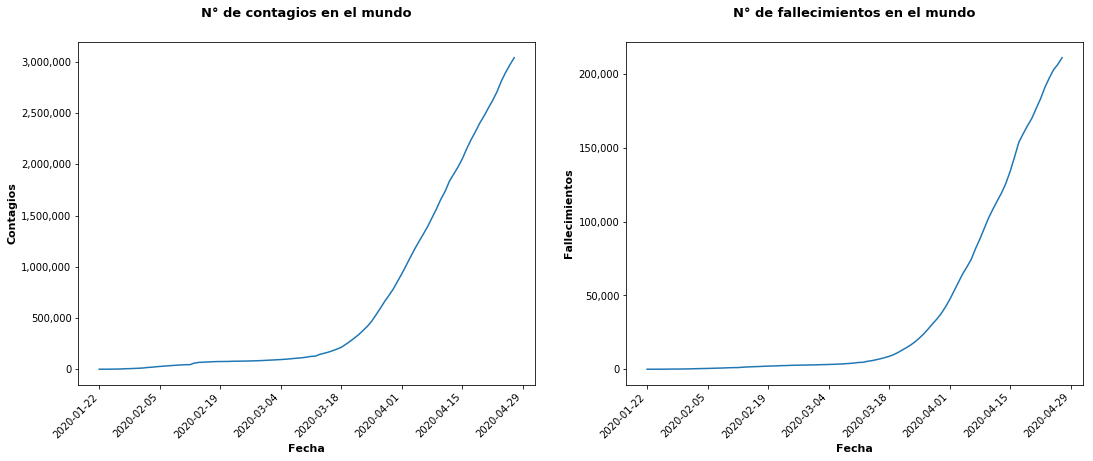

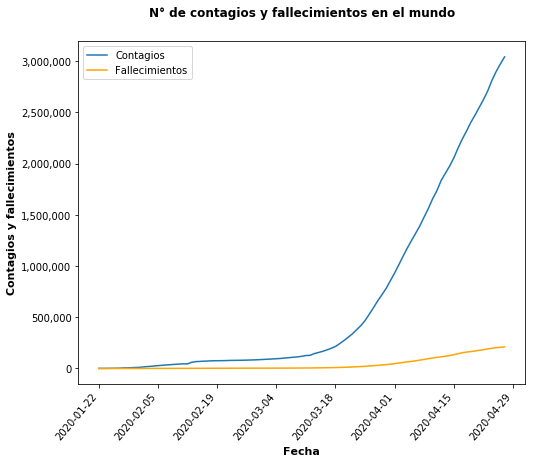

In [28]:
#Gráficos de evolución en el mundo

Paises3plot(world_trend_sum,'el mundo')

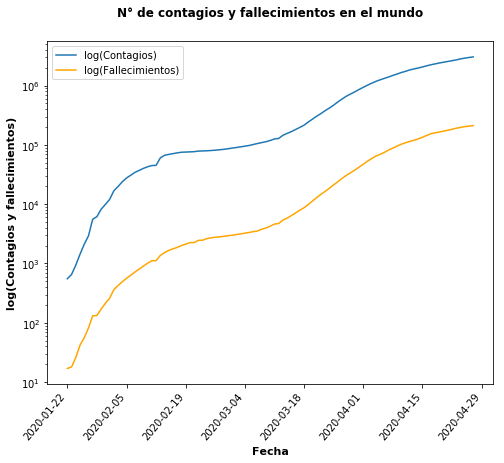

In [29]:
#Gráficos en escala logarítmica de evolución en el mundo

PaisesLog1plot(world_trend_sum,"el mundo")

Al graficar en escala logarítmica vemos el patrón similar que siguen contagios y fallecimientos, además se observa que en febrero la curva se había aplanado pero luego hubo un repunte a fines de marzo, esto puede deberse al relajo en las medidas de distanciamiento social, pero también al aumento de casos en regiones donde el virus llegó más tarde. 

In [30]:
#Veremos únicamente la tendencia en China

china_trend = train3.loc[train3["Country_Region"]=="China",:]
china_trend = china_trend.set_index('Date') #Dejamos fechas en la columna de índices
china_trend = china_trend.iloc[:,1:] #Dejo fuera el Id

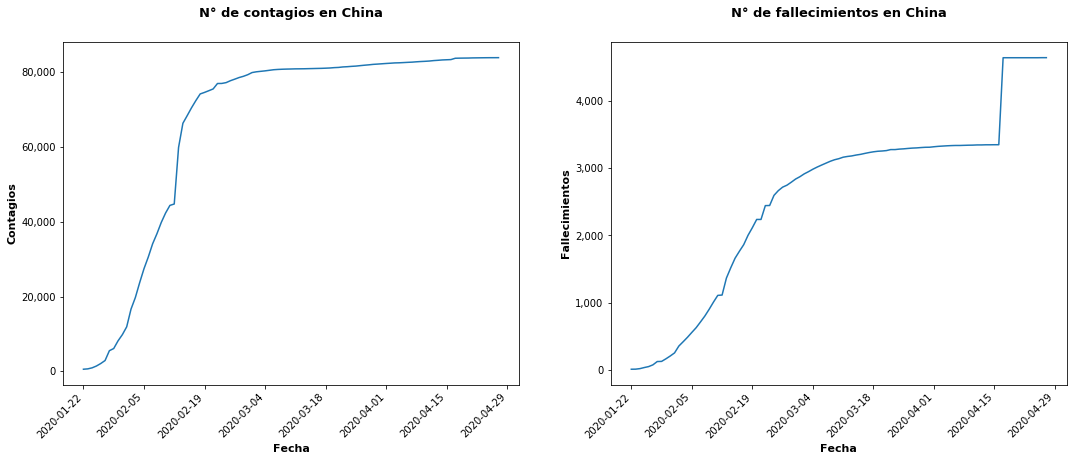

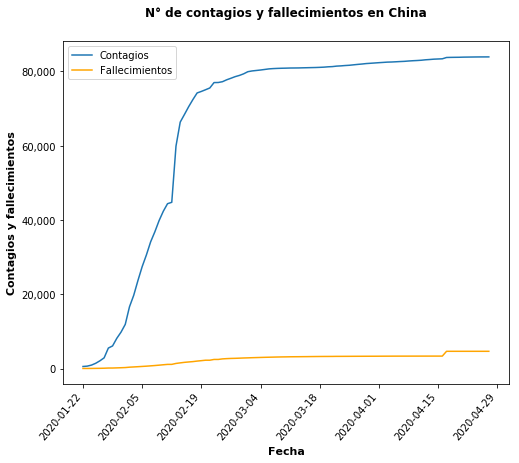

In [31]:
#Gráficos para China

Paises3plot(china_trend,"China")

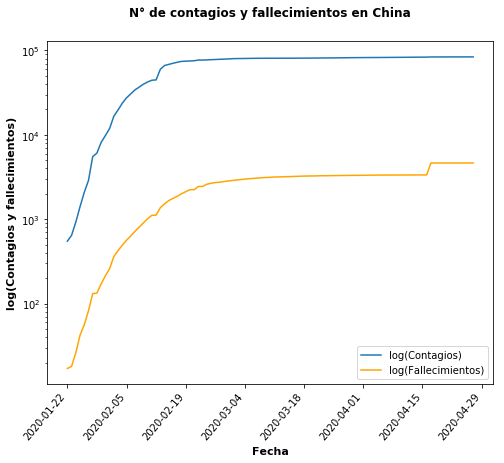

In [32]:
#Gráficos de China en estala logarítmica

PaisesLog1plot(china_trend,"China")

A partir de los gráficos vemos que la evolución de contagios en el mundo se muestra exponencial en un comienzo. En algunos países el virus lleva muy poco tiempo para conocer la evolución que tendrá después, pero para tener una intuición de lo que sucederá podemos observar el caso particular de China, en el cual tenemos un período de tiempo mucho mayor desde que iniciaron los contagios (ya que aquí comenzó la pandemia). Allí se observa un crecimiento de contagios y fallecimientos aproximadamente logístico, con un crecimiento rápido al inicio y un aplanamiento posterior de la curva. Lo que diferenciará a un país de otro es cuánto tiempo se mantiene la tasa de crecimiento exponencial y cuánto se tardará en lograr aplanar la curva, que es el objetivo final.

Se debe considerar que, a diferencia de China, los demás países tuvieron un período de tiempo para prepararse antes de que el virus llegara, por lo que se espera que la evolución de la enfermedad tenga varias diferencias con lo que ocurrió en China, al menos a priori.

Llama la atención que en China hay un repunte abrupto hacia el 15 de abril, esto último podría deberser a que China actualizó el número de víctimas fatales y modificó las cifras de un momento a otro. 
Visualizaremos la tendencia en el mundo sin considerar China, y luego las tendencias de otros países.


In [33]:
#Tendencia mundial sin considerar China
world_trend_noChina = train3.loc[train3["Country_Region"]!="China",:]

In [34]:
world_trend_noChina_group = world_trend_noChina.groupby("Date") #Agrupo por fecha
world_trend_noChina_cases = world_trend_noChina_group.agg({'ConfirmedCases':['sum']}) #Data set con solo fechas y suma de todos los 
                                                                #contagios por fecha
world_trend_noChina_fatal = world_trend_noChina_group.agg({'Fatalities':['sum']})    #Data set con solo fechas y suma de todos los
                                                               #los fallecimientos por fecha
world_trend_noChina_sum = world_trend_noChina_cases.join(world_trend_noChina_fatal)    #Unirmos los 2 dataset para tener los datos necesarios

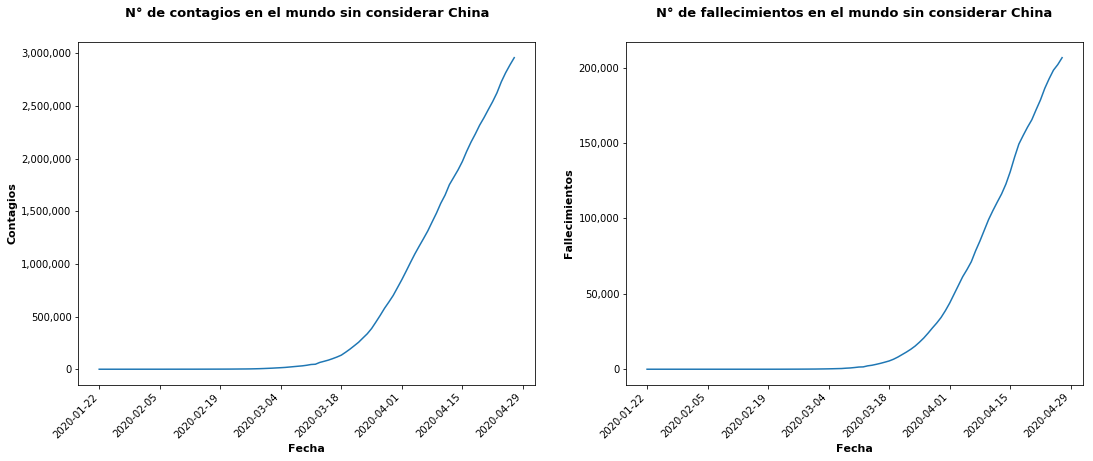

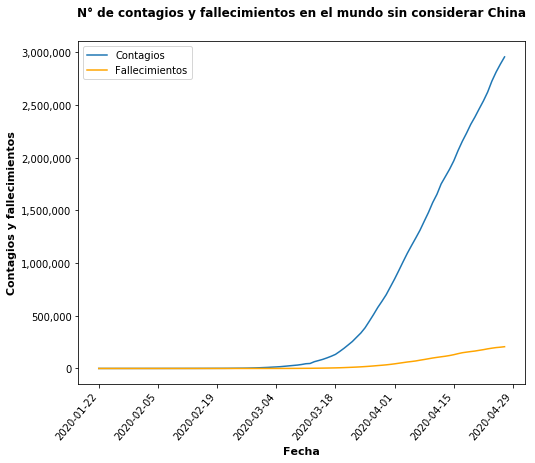

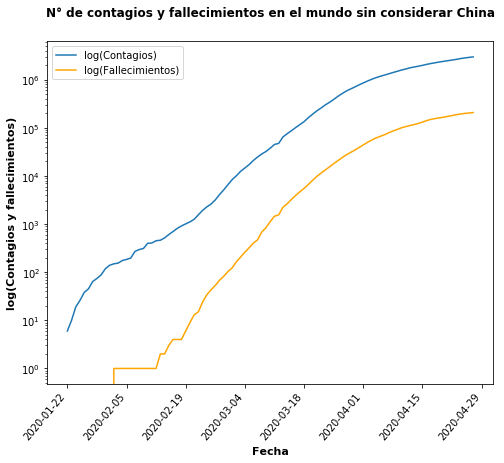

In [35]:
Paises3plot(world_trend_noChina_sum,"el mundo sin considerar China")
PaisesLog1plot(world_trend_noChina_sum,"el mundo sin considerar China")

Cuando no se consideara China los contagios y fallecimientos comienzan más tarde, pero la forma de la curva no se 
ve muy distinta y en el mundo en general aún no se ha logrado aplanar la curva en el período considerado. 

In [36]:
#Tendencia en EEUU
us_trend = train3.loc[train3["Country_Region"]=="US",:]
us_trend = us_trend.set_index('Date') #Dejamos fechas en la columna de índices
us_trend = us_trend.iloc[:,1:] #Dejo fuera el Id


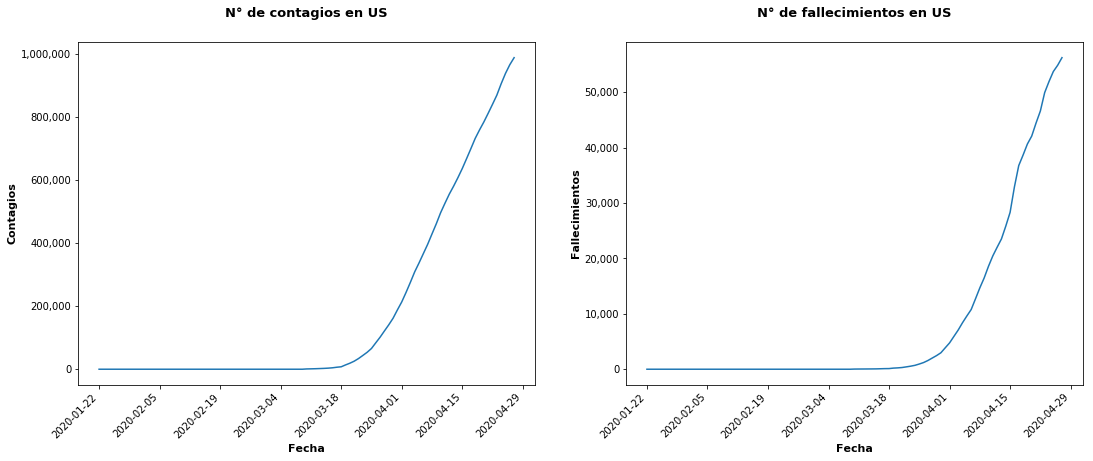

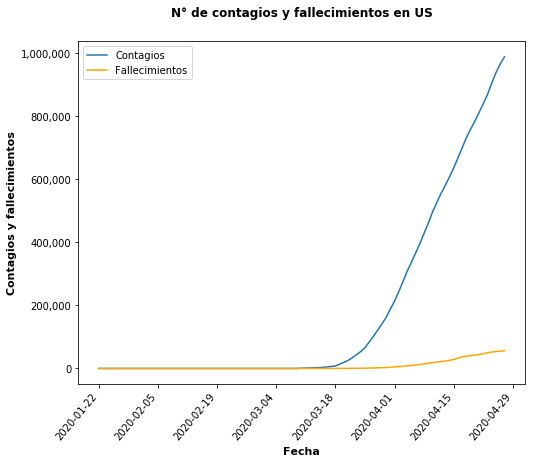

In [385]:
Paises3plot(us_trend,"US")
#PaisesLog1plot(us_trend,"US")

Vemos que en Estados Unidos la curva de casos crece rápidamente cuando comienzan los contagios, lo mismo ocurre con
fallecimientos, veremos qué ocurre al graficar la tendencia en el mundo sin considerar China ni EEUU.

In [38]:
#Gráficos sin China ni EEUU
world_trend2 = train3.loc[(train3["Country_Region"]!="China") & (train3["Country_Region"]!="US"),:]

In [39]:
world_trend2 = world_trend2.groupby("Date") #Agrupo por fecha

world_trend2_cases = world_trend2.agg({'ConfirmedCases':['sum']}) #Data set con solo fechas y suma de todos los 
                                                                #contagios por fecha
world_trend2_fatal = world_trend2.agg({'Fatalities':['sum']})    #Data set con solo fechas y suma de todos los
                                                               #los fallecimientos por fecha
world_trend2_sum = world_trend2_cases.join(world_trend2_fatal)

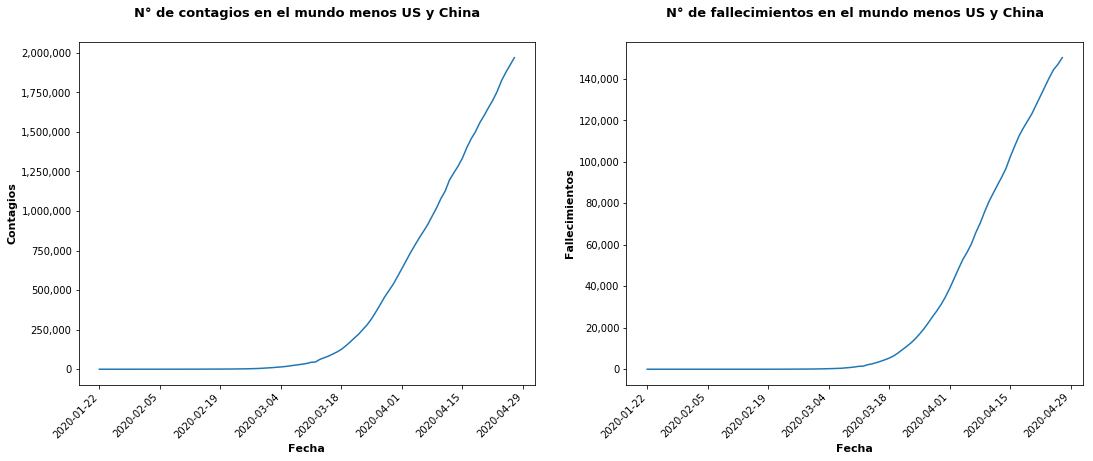

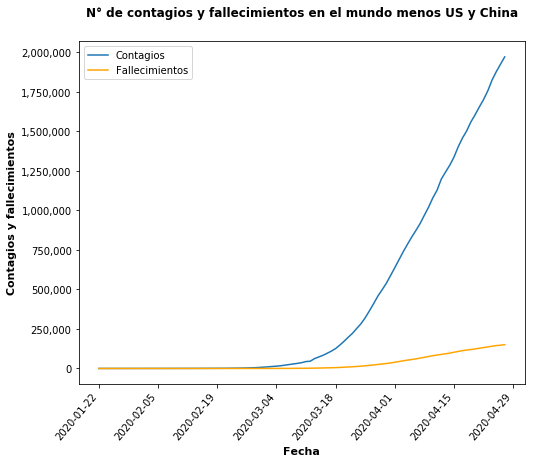

In [386]:
Paises3plot(world_trend2_sum,"el mundo menos US y China")
#PaisesLog1plot(world_trend2_sum,"el mundo menos US y China")

La forma que tiene la curva de tendencia en contagios y fallecimiento en el mundo varía poco al dejar de considerar US y China (solo hay menos casos).

Mostraremos los 10 países con mayor n° de contagios y mayor cantidad de fallecimientos

In [42]:
#Última fecha de la que se tiene registro: 27-04-2020
#Países con mayor cantidad de casos al 27-abril
max_paises = train3.loc[train3['Date']=="2020-04-27",:]
#es lo mismo que train3[train3['Date']=="2020-04-27"]

In [43]:
#10 países con más contagios
max_contagios = max_paises.nlargest(10,"ConfirmedCases")
#10 países con mayor mortalidad
max_mort = max_paises.nlargest(10,"Fatalities")


In [44]:
display(max_contagios)
display(max_mort)


,Id,Country_Region,Date,ConfirmedCases,Fatalities
17835,1627344,US,2020-04-27,988031.0,56254.0
17820,25405,Spain,2020-04-27,229422.0,23521.0
17748,16741,Italy,2020-04-27,199414.0,26977.0
17725,149039,France,2020-04-27,165963.0,23327.0
17729,14575,Germany,2020-04-27,158758.0,6126.0
17839,376013,United Kingdom,2020-04-27,158348.0,21157.0
17834,27001,Turkey,2020-04-27,112261.0,2900.0
17744,16285,Iran,2020-04-27,91472.0,5806.0
17802,23353,Russia,2020-04-27,87147.0,794.0
17700,266541,China,2020-04-27,83918.0,4637.0


,Id,Country_Region,Date,ConfirmedCases,Fatalities
17835,1627344,US,2020-04-27,988031.0,56254.0
17748,16741,Italy,2020-04-27,199414.0,26977.0
17820,25405,Spain,2020-04-27,229422.0,23521.0
17725,149039,France,2020-04-27,165963.0,23327.0
17839,376013,United Kingdom,2020-04-27,158348.0,21157.0
17680,2719,Belgium,2020-04-27,46687.0,7207.0
17729,14575,Germany,2020-04-27,158758.0,6126.0
17744,16285,Iran,2020-04-27,91472.0,5806.0
17700,266541,China,2020-04-27,83918.0,4637.0
17687,3517,Brazil,2020-04-27,67446.0,4603.0


In [45]:
nombres_max_contagios = max_contagios["Country_Region"].tolist()
nombres_max_mort = max_mort["Country_Region"].tolist()

In [46]:
#Función para graficar en un mismo gráfico varios países, usaré este código varias veces, para graficar un determinado
#n°de países con mayor cantidad de contagios, luego los que tienen mayor cantidad de fallecimientos

def VariosPaisesPlot(timeserie, lista_paises, titulo, logScale = False):
   #2 gráficos: contagios y fallecimientos, representando varios países
    #dataframe que contenga las columnas "ConfirmedCases" y "Fatalities"
    #lista_paises debe ser una lista   
    #titulo: va un string, puede ser "contagios" o "fallecimientos" dependiendo de si son los 10 países con mayor
    #n° de contagios o los 10 países con mayor número de fallecimientos
    #logScale es un boolean para decidir si queremos mostrar gráfico en escala logarítmica o no
    #por defecto es false
    
    n_paises = str(len(lista_paises))
    #Filtramos el dataset según la lista de países entregada
    paisesN = timeserie.loc[timeserie["Country_Region"].isin(lista_paises),:]
    paisesN = paisesN.set_index('Date') #Dejamos fechas en la columna de índices
    
    #Agrupamos el dataset por países
    paisesNgroup = paisesN.groupby('Country_Region')
    
    #Graficamos
    fig, ax = plt.subplots(1,2,figsize=(18,7))  
    #(1)
    ax[0].set_title('N° de contagios en '+n_paises+' países con mayor n° de '+titulo, fontsize=13, loc='center', 
                        fontdict=dict(weight='bold'), pad=25)
    ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
    ax[0].set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold')) 
    ax[0].set_ylabel('Contagios', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)
    if (logScale):
        ax[0].set_yscale('log')
    for name, group in paisesNgroup:
        ax[0].plot(group['ConfirmedCases'], label = name)
    ax[0].legend()
      
    #(2)
    ax[1].set_title('N° de fallecimientos en '+n_paises+' países con mayor n° de '+titulo, fontsize=13, loc='center',
                        fontdict=dict(weight='bold'), pad=25)
    ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[1].set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold'))
    ax[1].set_ylabel('Fallecimientos', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)
    if (logScale):
        ax[1].set_yscale('log')
    for name, group in paisesNgroup:
        ax[1].plot(group['Fatalities'], label = name)
    ax[1].legend()
  

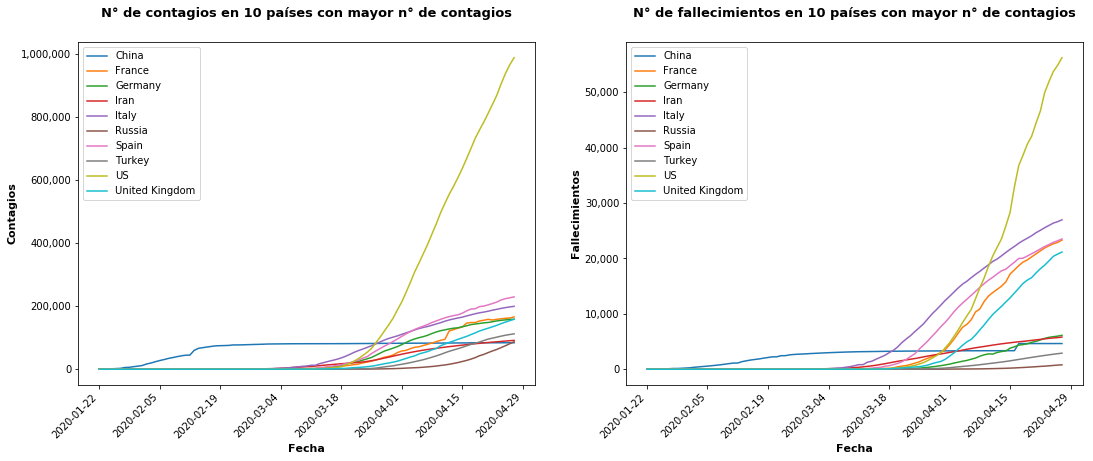

In [113]:
#Gráfico de países con mayor cantidad de contagios
VariosPaisesPlot(train3,nombres_max_contagios,'contagios')

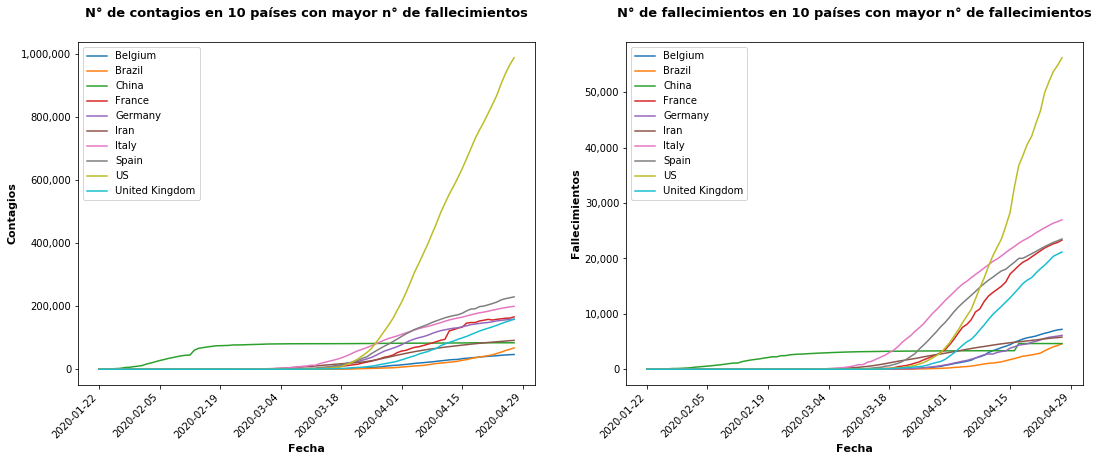

In [48]:
#Gráfico de países con mayor cantidad de fallecimientos
VariosPaisesPlot(train3,nombres_max_mort,'fallecimientos')

Notamos que Estados Unidos muestra un crecimiento mucho más pronunciado que en los demás países tanto en número de contagios como fallecimientos, China logró aplanar la curva de contagios y fallecimientos a mediados de ferebro. Italia es el segundo país con mayor número de fallecimientos después de US, después España, Francia y Reino Unido. La curva de Brasil comienza a crecer recién a principios de abril, considerando la última fecha de el dataset se ve que el número de contagios y fallecimientos está aumentando.

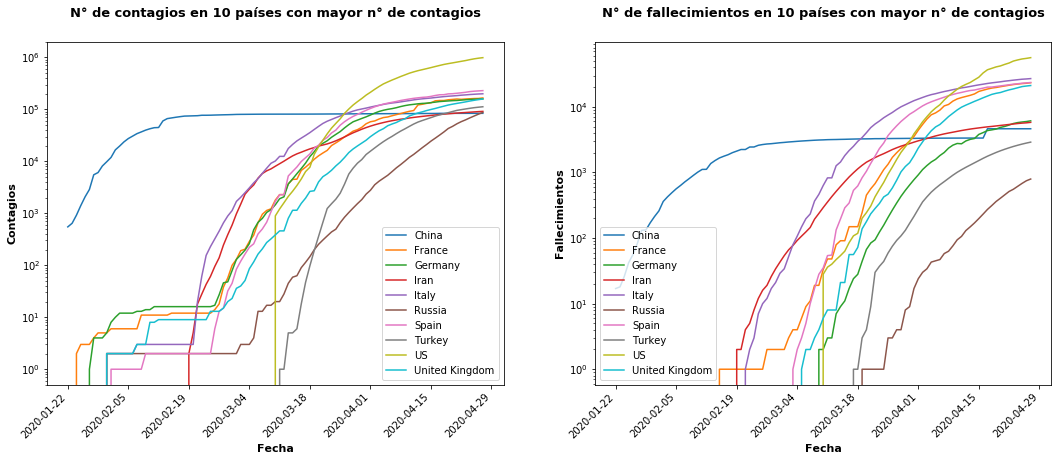

In [49]:
#Gráfico de países con mayor cantidad de contagios en escala logarítmica
VariosPaisesPlot(train3,nombres_max_contagios,'contagios',True)

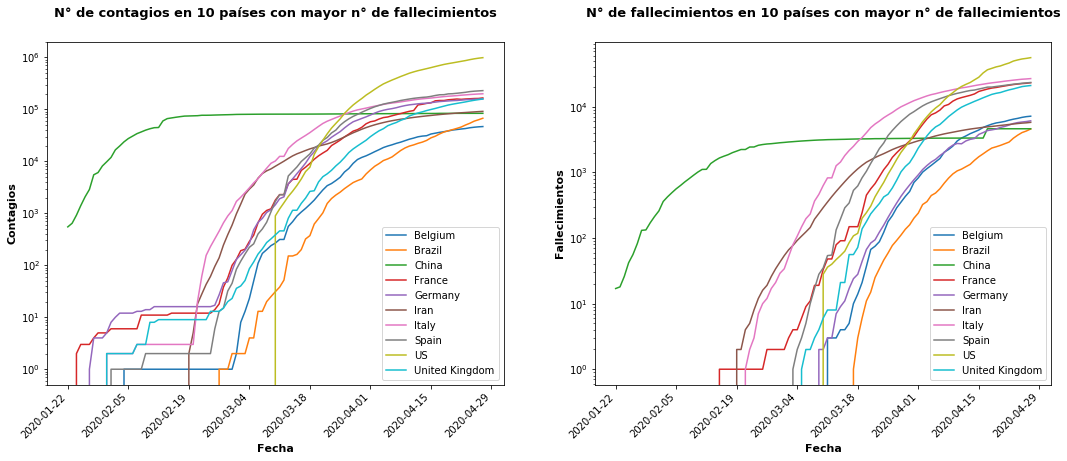

In [50]:
#Gráfico de países con mayor cantidad de fallecimientos en escala logarítmica
VariosPaisesPlot(train3,nombres_max_mort,'fallecimientos',True)

In [51]:
#Añadiremos al dataframe una columna con la tasa de mortalidad para graficarla para los 10 países con más fallecimientos
train3["Mortality_rate"] = (train3["Fatalities"]/train3["ConfirmedCases"]).fillna(0)

In [52]:
#Gráfico de taza de mortalidad
def PlotMortRate(timeserie, lista_paises, titulo, logScale = False):
    #dataframe que contenga la columna "Mortality_rate"
    #lista_paises debe ser una lista 
    #titulo: va un string, puede ser "contagios" o "fallecimientos"
    #logScale es un boolean para decidir si queremos mostrar gráfico en escala logarítmica o no
    #por defecto es false
    
    n_paises = str(len(lista_paises))
    #Filtramos el dataset según la lista de países entregada
    paisesN = timeserie.loc[timeserie["Country_Region"].isin(lista_paises),:]
    paisesN = paisesN.set_index('Date') #Dejamos fechas en la columna de índices
    
    #Agrupamos el dataset por países
    paisesNgroup = paisesN.groupby('Country_Region')
    
    #Graficamos
    fig, ax = plt.subplots(figsize=(18,7))  
    ax.set_title('Tasa de fallecimientos por contagiados en '+n_paises+' países con mayor n° de '+titulo, 
                 fontsize=13, loc='center', fontdict=dict(weight='bold'), pad=25)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
    ax.set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold')) 
    ax.set_ylabel('Tasa fallecidos/contagiados', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)
    if (logScale):
        ax.set_yscale('log')
    for name, group in paisesNgroup:
        ax.plot(group['Mortality_rate'], label = name)
    ax.legend()

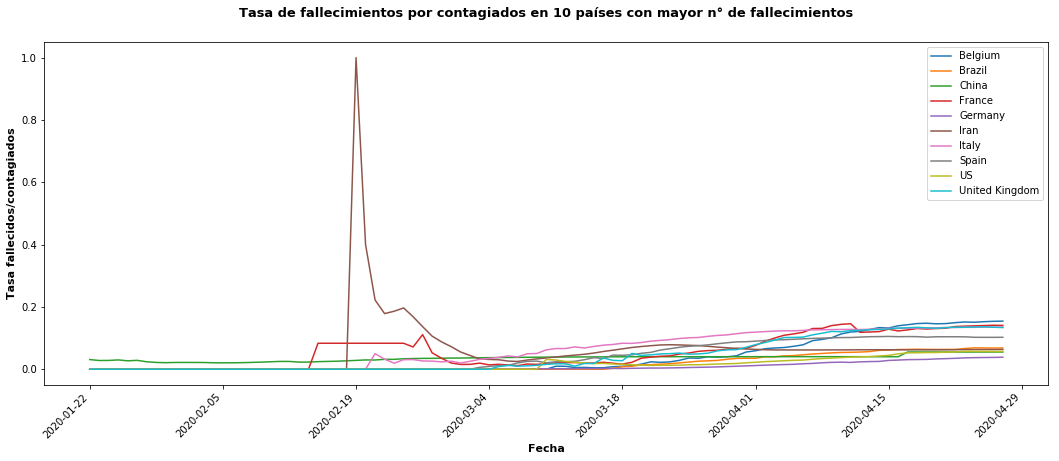

In [53]:
#Tasa de mortalidad para los 10 países con mayor cantidad de fallecidos
PlotMortRate(train3, nombres_max_mort, "fallecimientos")

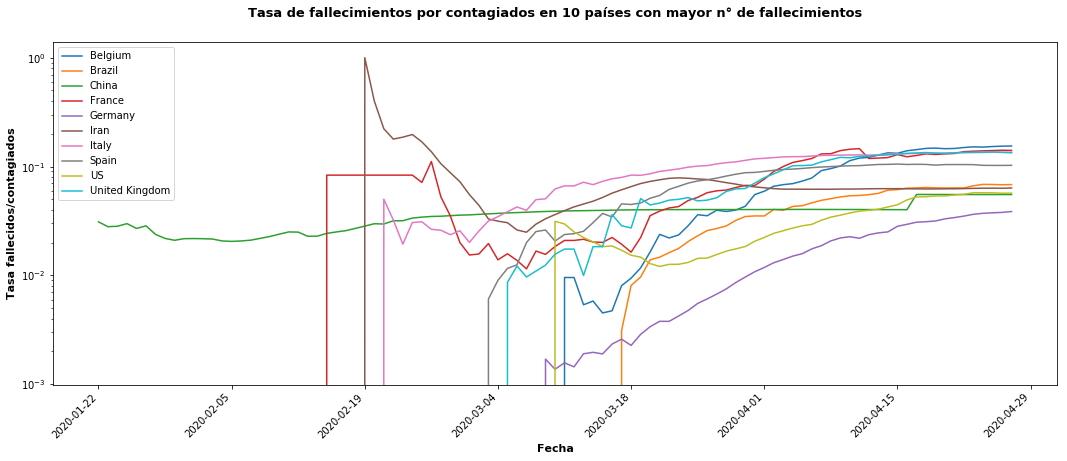

In [54]:
#Tasa de mortalidad para los 10 países con mayor cantidad de fallecidos en escala logarítmica
PlotMortRate(train3, nombres_max_mort, "fallecimientos",True)

* En el gráfico se observa que en Irán la tasa de fallecidos por contagiados fue muy alta cuando el virus entró a ese país, pero el comportamiento inicial no explica necesariamente lo que ocurrirá unos días después. Por ejemplo, puede que en los primeros días de contagio haya fallecido el 50% de los contagiados pero que el total de contagiados fuera 10, entonces no se puede concluir que el país ha manejado mal la situación con tan poca cantidad de contagiados y considerando un período de tiempo tan corto; con el tiempo esa tasa de fallecidos/contagiados variará considerablemente.


* En el caso de China la tasa se ha mantenido relativamente estable a lo largo del tiempo. En los países analizados al final del período se puede observar que la tasa de fallecimientos por contagiados se va estabilidando en el tiempo. Vamos a graficar desde una fecha más adelante para dejar fuera el comienzo de los contagios en los países y evitar outliers.

In [55]:
#Gráfico de taza de mortalidad a partir de una fecha indicada como parámetro de entrada
def PlotMortRateDate(timeserie, lista_paises, titulo, date_ini, logScale = False):
    #dataframe que contenga la columna "Mortality_rate"
    #lista_paises debe ser una lista 
    #titulo: va un string, puede ser "contagios" o "fallecimientos" dependiendo de si son los 10 países con mayor
    #n° de contagios o los 10 países con mayor número de fallecimientos
    #logScale es un boolean para decidir si queremos mostrar gráfico en escala logarítmica o no
    #por defecto es false
    #date_ini es un string marcando la fecha desde la cual se va a graficar
    
    n_paises = str(len(lista_paises))
    #Filtramos el dataset según la lista de países entregada
    paisesN = timeserie.loc[timeserie["Country_Region"].isin(lista_paises),:]
    #paisesN = paisesN.set_index('Date') #Dejamos fechas en la columna de índices
    
    #Filtramos según la fecha inicial indicada
    paisesN = paisesN[paisesN["Date"]>=date_ini] 
    
    #Agrupamos el dataset por países
    paisesNgroup = paisesN.groupby('Country_Region')
    
    
    #Graficamos
    fig, ax = plt.subplots(figsize=(18,7))  
    ax.set_title('Tasa de fallecimientos por contagiados en '+n_paises+' países con mayor n° de '+titulo, 
                 fontsize=13, loc='center', fontdict=dict(weight='bold'), pad=25)
    #ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
    ax.set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold')) 
    ax.set_ylabel('Tasa fallecidos/contagiados', fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)
    if (logScale):
        ax.set_yscale('log')
    for name, group in paisesNgroup:
        ax.plot(group['Date'],group['Mortality_rate'], label = name)
    ax.legend()

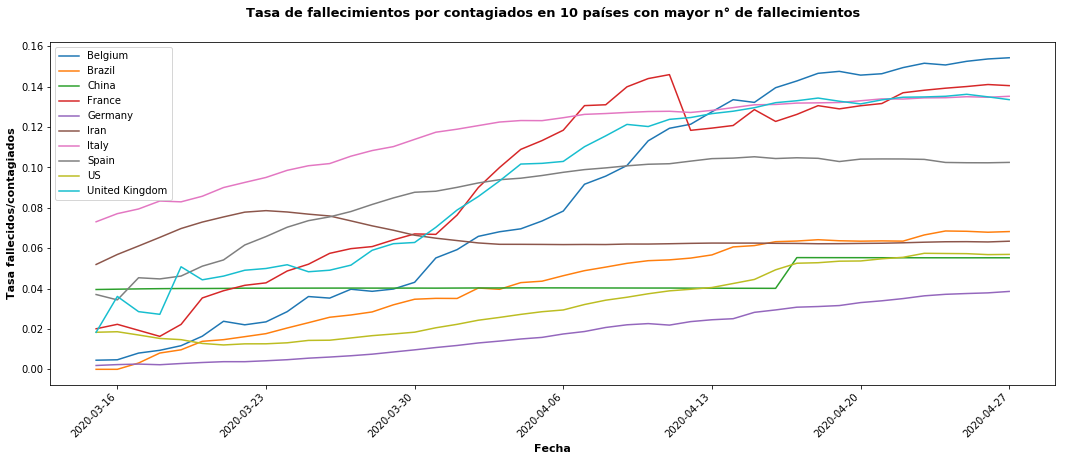

In [56]:
PlotMortRateDate(train3, nombres_max_mort, "fallecimientos",'2020-03-15')

In [387]:
#PlotMortRateDate(train3, nombres_max_mort, "fallecimientos",'2020-03-15',True)

Si se compara la tasa de fallecimientos por contagiados entre los países más afectados por la pandemia, se observa que la tasa de US está más baja que la de varios países, la más baja es la de Alemania, mientras que el país que se alza con la mayor tasa es Bélgica,

### Datos extras

In [58]:
#Añadiremos el dato de población de cada país a partir de otra fuente, para así obtener las razones
#contagios/población y fallecimiento/población, y ver cómo afecta el número de habitantes.

In [59]:
#Mis agradecimientos a la persona que creó este dataset:
#https://www.kaggle.com/tanuprabhu/population-by-country-2020

country_data = pd.read_csv("data/otros datos/datasets_507962_1091873_population_by_country_2020.csv")

In [60]:
country_data.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1438207241,0.39 %,5540090,153,9388211,-348399.0,1.7,38,61 %,18.47 %
1,India,1377233523,0.99 %,13586631,464,2973190,-532687.0,2.2,28,35 %,17.70 %
2,United States,330610570,0.59 %,1937734,36,9147420,954806.0,1.8,38,83 %,4.25 %
3,Indonesia,272931713,1.07 %,2898047,151,1811570,-98955.0,2.3,30,56 %,3.51 %
4,Pakistan,219992900,2.00 %,4327022,287,770880,-233379.0,3.6,23,35 %,2.83 %


In [61]:
country_data = country_data.sort_values("Country (or dependency)")

Vamos a quedarnos con las columnas "Population", "Density", "Land Area" y "Med. Age" para  calcular las razones 
contagiados/población y fallecimienos/poblacióne. Además estudiaremos si existe alguna correlación entre
contagios/fallecimientos y esas variables que conservaremos.

In [62]:
country_data = country_data[["Country (or dependency)","Population (2020)", "Density (P/Km²)", "Land Area (Km²)","Med. Age"]] 

In [63]:
#Renombramos algunas columnas para simplificar la lectura
country_data = country_data.rename(columns={'Country (or dependency)': 'Country_Region', 'Population (2020)': 'Population',
                                           'Density (P/Km²)':'Density', 'Land Area (Km²)':'Land_area','Med. Age':'Med_age'})

In [64]:
#Cambiaremos el nombre de algunos países de country_data para que sean iguales a los del dataset original:

# United States --> US
# Czech Republic (Czechia) --> Czechia
# DR Congo --> Congo (Kinshasa)
# Côte d'Ivoire --> Cote d'Ivoire
# South Korea --> Korea, South
# Saint Kitts & Nevis --> Saint Kitts and Nevis
# Sao Tome & Principe -> Sao Tome and Principe
# St. Vincent & Grenadines --> Saint Vincent and the Grenadines
# Taiwan --> Taiwan*


country_data = country_data.replace(to_replace ="United States", value ="US") 
country_data = country_data.replace(to_replace ="Czech Republic (Czechia)", value ="Czechia") 
country_data = country_data.replace(to_replace ="DR Congo", value ="Congo (Kinshasa)") 
country_data = country_data.replace(to_replace ="Côte d'Ivoire", value ="Cote d'Ivoire") 
country_data = country_data.replace(to_replace ="South Korea", value ="Korea, South") 
country_data = country_data.replace(to_replace ="Saint Kitts & Nevis", value ="Saint Kitts and Nevis") 
country_data = country_data.replace(to_replace ="Sao Tome & Principe", value ="Sao Tome and Principe")
country_data = country_data.replace(to_replace ="St. Vincent & Grenadines", value ="Saint Vincent and the Grenadines") 
country_data = country_data.replace(to_replace ="Taiwan", value ="Taiwan*") 

In [65]:
print(len(train3["Country_Region"].unique()))
print(len(country_data["Country_Region"].unique()))

184
235


In [66]:
#Hacemos el join de los 2 dataset
joined_data = pd.merge(left=train3, right=country_data, how='left', 
                       left_on='Country_Region', right_on='Country_Region') 

In [67]:
joined_data.describe()

,Id,ConfirmedCases,Fatalities,Mortality_rate,Population,Density,Land_area
count,1.784800e+04,17848.000000,17848.000000,17848.000000,1.726600e+04,17266.000000,1.726600e+04
mean,3.033548e+04,3595.810623,220.365083,0.016128,4.282158e+07,370.275281,7.146455e+05
std,1.230002e+05,29223.354423,1934.384626,0.045076,1.533795e+08,2068.311744,1.905756e+06
min,1.000000e+00,0.000000,0.000000,0.000000,8.010000e+02,2.000000,0.000000e+00
25%,1.151050e+04,0.000000,0.000000,0.000000,2.531290e+06,34.000000,2.805000e+04
50%,1.800400e+04,3.000000,0.000000,0.000000,9.868868e+06,89.000000,1.367600e+05
75%,2.381350e+04,176.000000,3.000000,0.013158,3.106736e+07,214.000000,5.691400e+05
max,1.627344e+06,988031.000000,56254.000000,1.000000,1.438207e+09,26337.000000,1.637687e+07


In [68]:
joined_data.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities,Mortality_rate,Population,Density,Land_area,Med_age
0,1,Afghanistan,2020-01-22,0.0,0.0,0.0,38742911.0,60.0,652860.0,18
1,2,Afghanistan,2020-01-23,0.0,0.0,0.0,38742911.0,60.0,652860.0,18
2,3,Afghanistan,2020-01-24,0.0,0.0,0.0,38742911.0,60.0,652860.0,18
3,4,Afghanistan,2020-01-25,0.0,0.0,0.0,38742911.0,60.0,652860.0,18
4,5,Afghanistan,2020-01-26,0.0,0.0,0.0,38742911.0,60.0,652860.0,18


In [69]:
#Añadiremos dos columnas, una con n°contagios/población y otra con n°fallecimientos/población

joined_data["ConfirmedCases_pop"] = joined_data["ConfirmedCases"]/joined_data["Population"]
joined_data["Fatalities_pop"] = joined_data["Fatalities"]/joined_data["Population"]

In [70]:
#Países con mayores razones contagio/población a la fecha 2020-04-27
max_paises2 = joined_data.loc[joined_data['Date']=="2020-04-27",:]

max_contagios_pob = max_paises2.nlargest(10,"ConfirmedCases_pop")
#Países con mayores razones fall/población
max_mort_pob = max_paises2.nlargest(10,"Fatalities_pop")

nombres_max_contagios_pob = max_contagios_pob["Country_Region"].tolist()
nombres_max_mort_pob = max_mort_pob["Country_Region"].tolist()

In [71]:
#Función para desplegar información de varios países en un mismo gráfico, además con la opción de seleccionar qué
#columna se desea graficar.

def VariosPaisesPlotCol(timeserie, lista_paises, feature, nombreY, titulo, logScale = False):
    #timeserie es el dataframe 
    #lista_paises debe ser una lista 
    #se graficará lo que se indique en feature, debe ser un string con el nombre exacto de la columna
    #nombreY es el nombre que le daremos al eje de las ordenadas
    #titulo: va un string con el título, personalizado
    #logScale es un boolean para decidir si queremos mostrar gráfico en escala logarítmica o no
    #por defecto es false
    
    n_paises = str(len(lista_paises))
    #Filtramos el dataset según la lista de países entregada
    paisesN = timeserie.loc[timeserie["Country_Region"].isin(lista_paises),:]
    paisesN = paisesN.set_index('Date') #Dejamos fechas en la columna de índices
    
    #Agrupamos el dataset por países
    paisesNgroup = paisesN.groupby('Country_Region')
    
    #Graficamos
    fig, ax = plt.subplots(1,1,figsize=(10,7))  

    ax.set_title(titulo, fontsize=13, loc='center', 
                        fontdict=dict(weight='bold'), pad=25)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}')) 
    ax.set_xlabel('Fecha', fontsize=11, fontdict=dict(weight='bold')) 
    ax.set_ylabel(nombreY, fontsize=11, fontdict=dict(weight='bold'))
    fig.autofmt_xdate(rotation=45)
    if (logScale):
        ax.set_yscale('log')
    for name, group in paisesNgroup:
        ax.plot(group[feature], label = name)
    ax.legend()

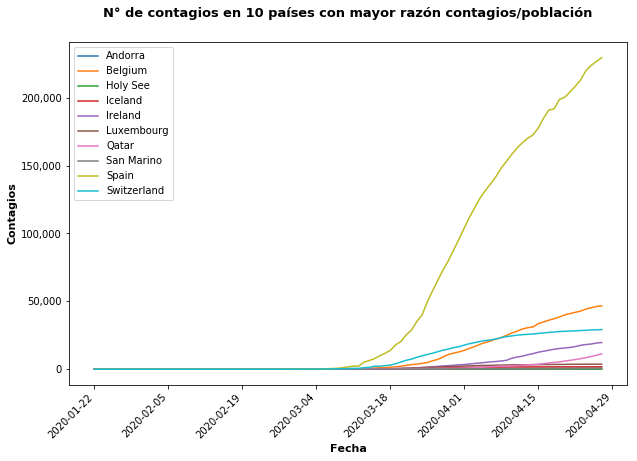

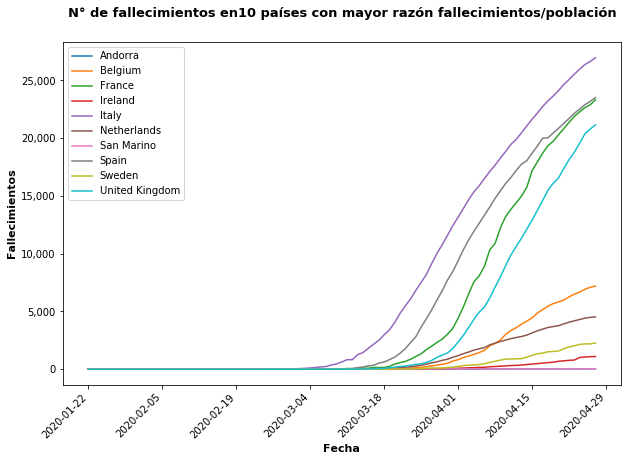

In [72]:
#Gráfico de contagios en 10 países con mayor razón contagios/población
VariosPaisesPlotCol(joined_data, nombres_max_contagios_pob, 'ConfirmedCases', 'Contagios', 'N° de contagios en\
 10 países con mayor razón contagios/población')

#Gráfico de fallecimientos en 10 países con mayor razón fallecimientos/población
VariosPaisesPlotCol(joined_data, nombres_max_mort_pob, 'Fatalities', 'Fallecimientos', 'N° de fallecimientos en\
10 países con mayor razón fallecimientos/población')


Si analizamos el n° de contagios por cantidad de población observamos que el país con mayor razón contagios/población 
es España, seguido por Bélgica y Suiza.

Si miramos la razón fallecimientos/población, los países más afectados son Italia, España, Francia y Reino Unido. 

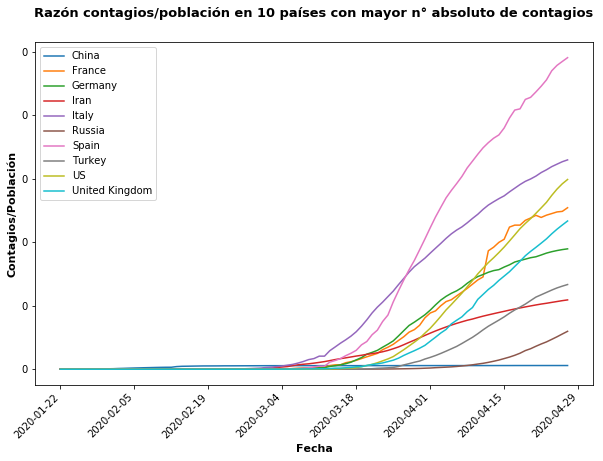

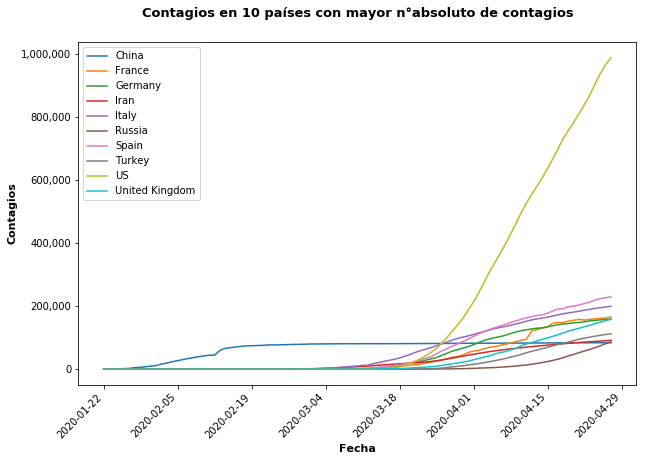

In [73]:
#Gráfico de razón contagios/población en 10 países con mayor n° absoluto de contagios
VariosPaisesPlotCol(joined_data, nombres_max_contagios, 'ConfirmedCases_pop', 'Contagios/Población', 'Razón contagios\
/población en 10 países con mayor n° absoluto de contagios')

#Para comparar:
#Gráfico de contagios en 10 países con mayor n° absoluto de contagios
VariosPaisesPlotCol(joined_data,nombres_max_contagios,'ConfirmedCases', 'Contagios','Contagios en 10 países con mayor n°\
absoluto de contagios')


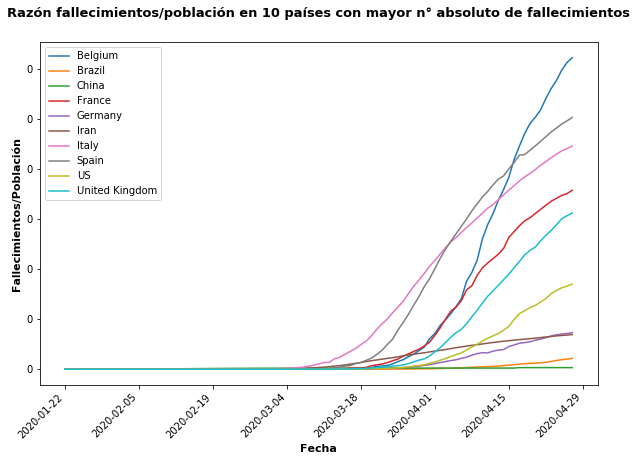

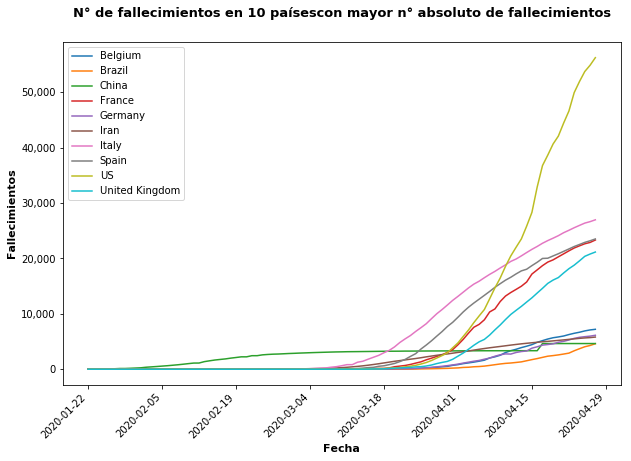

In [74]:
#Gráfico de razón fallecimientos/población en 10 países con mayor n° absoluto de fallecimientos
VariosPaisesPlotCol(joined_data, nombres_max_mort, 'Fatalities_pop', 'Fallecimientos/Población', 'Razón falle\
cimientos/población en 10 países con mayor n° absoluto de fallecimientos')

#Para comparar
#Gráfico de fallecimientos en 10 países con mayor n° absoluto de fallecimientos
VariosPaisesPlotCol(train3,nombres_max_mort,'Fatalities','Fallecimientos', 'N° de fallecimientos en 10 países\
con mayor n° absoluto de fallecimientos')

### Exploración de los datos extras

In [75]:
#Datos acumulados: última fecha
joined_data_acc = joined_data.loc[joined_data['Date']=="2020-04-27",:]
joined_data_acc.head()

,Id,Country_Region,Date,ConfirmedCases,Fatalities,Mortality_rate,Population,Density,Land_area,Med_age,ConfirmedCases_pop,Fatalities_pop
96,97,Afghanistan,2020-04-27,1703.0,57.0,0.033470,38742911.0,60.0,652860.0,18,4.395643e-05,1.471237e-06
193,211,Albania,2020-04-27,736.0,28.0,0.038043,2878420.0,105.0,27400.0,36,2.556958e-04,9.727559e-06
290,325,Algeria,2020-04-27,3517.0,432.0,0.122832,43685618.0,18.0,2381740.0,29,8.050704e-05,9.888838e-06
387,439,Andorra,2020-04-27,743.0,40.0,0.053836,77240.0,164.0,470.0,N.A.,9.619368e-03,5.178664e-04
484,553,Angola,2020-04-27,27.0,2.0,0.074074,32644783.0,26.0,1246700.0,17,8.270847e-07,6.126553e-08


In [76]:
#Eliminar filas con NA
joined_data_acc = joined_data_acc.dropna()

In [77]:
na = np.where(joined_data_acc["Med_age"]=='N.A.')

#joined_data_acc.iloc[na]

In [78]:
#Eliminamos las filas con 'N.A' porque no hay información de la edad promedio (esto pensando en los próximos gráficos)
#joined_data_acc = joined_data_acc.loc
joined_data_acc = joined_data_acc.iloc[np.where(joined_data_acc["Med_age"]!='N.A.')]

In [79]:
joined_data_acc["Med_age"] = pd.to_numeric(joined_data_acc["Med_age"]) #convertimos en int

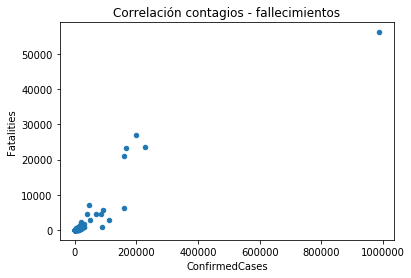

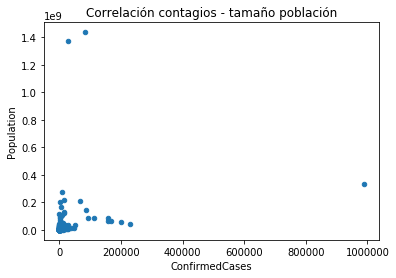

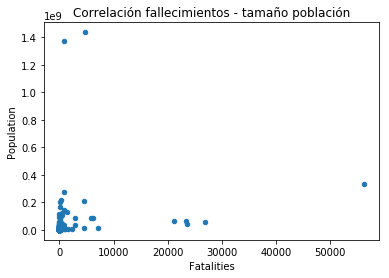

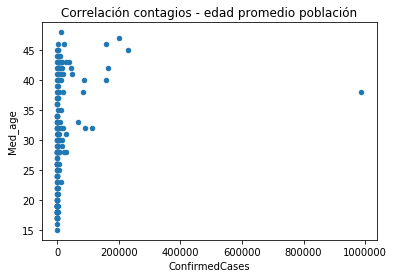

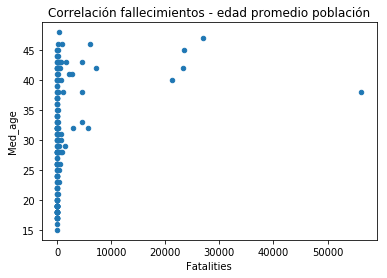

In [80]:
#Gráficos de correlaciones
joined_data_acc.plot(kind="scatter", x="ConfirmedCases", y="Fatalities", title="Correlación contagios - fallecimientos")
joined_data_acc.plot(kind="scatter", x="ConfirmedCases", y="Population", title=
                    'Correlación contagios - tamaño población')
joined_data_acc.plot(kind="scatter", x="Fatalities", y="Population", title=
                    'Correlación fallecimientos - tamaño población')
joined_data_acc.plot(kind="scatter", x="ConfirmedCases", y="Med_age", title=
                    'Correlación contagios - edad promedio población')
joined_data_acc.plot(kind="scatter", x="Fatalities", y="Med_age", title=
                    'Correlación fallecimientos - edad promedio población')



In [81]:
joined_data_acc.corr()

,Id,ConfirmedCases,Fatalities,Mortality_rate,Population,Density,Land_area,Med_age,ConfirmedCases_pop,Fatalities_pop
Id,1.000000,0.925251,0.814745,0.093867,0.239663,-0.015851,0.371623,0.103890,0.215450,0.208835
ConfirmedCases,0.925251,1.000000,0.932756,0.166162,0.218215,-0.016775,0.405292,0.203741,0.371314,0.407296
Fatalities,0.814745,0.932756,1.000000,0.297528,0.175473,-0.023274,0.292551,0.241429,0.452299,0.620791
Mortality_rate,0.093867,0.166162,0.297528,1.000000,0.048143,-0.100518,0.029485,0.080049,0.160759,0.465459
Population,0.239663,0.218215,0.175473,0.048143,1.000000,0.006821,0.441438,0.022782,-0.045394,-0.003306
Density,-0.015851,-0.016775,-0.023274,-0.100518,0.006821,1.000000,-0.085420,0.135993,0.159116,-0.009309
Land_area,0.371623,0.405292,0.292551,0.029485,0.441438,-0.085420,1.000000,0.073676,0.004752,0.004707
Med_age,0.103890,0.203741,0.241429,0.080049,0.022782,0.135993,0.073676,1.000000,0.487634,0.392223
ConfirmedCases_pop,0.215450,0.371314,0.452299,0.160759,-0.045394,0.159116,0.004752,0.487634,1.000000,0.711854
Fatalities_pop,0.208835,0.407296,0.620791,0.465459,-0.003306,-0.009309,0.004707,0.392223,0.711854,1.000000


In [82]:
from scipy.stats.stats import pearsonr

In [83]:
pearsonr(joined_data_acc["ConfirmedCases"],joined_data_acc["Fatalities"])

(0.9327560835377459, 8.626740472601905e-77)

Al observar la relación entre distintas variables, la única relación clara es la que existe entre n° de contagios y n°
de fallecimientos. No se observa una correlación entre contagios/fallecimientos y tamaño población/edad promedio. 
Sin emabargo, sería interesante ver las edades de los contagiados y fallecidos para poder encontrar alguna relación entre contagios/fallecimientos y las edades de los contagiados y fallecidos, es posible que se observe una relación
distinta que al considerar la población total de los países.

### Proyecciones

**SIR Model**

El modelo SIR es un modelo matemático que describe la propagación de una enfermedad. Este modelo divide la población de *N* individuos en tres grupos, cada uno de los cuales varía en función del tiempo, _t_ :
* S(t): Individuos susceptibles de contagiarse (aun no se contagian)
* I(t): Individuos contagiados
* R(t): Individuos recuperados que ahora tienen inmunidad a la enfermedad e individuos fallecidos

El modelo describe el cambio en la población de cada grupo en términos de los parámetros $\beta$ y $\gamma$. El parámetro $\beta$ es la tasa de **transmisión** y $\gamma$ es la tasa de **recuperación** (por lo tanto el período medio de recuperación es 1/$\gamma$). La población total es N = S+I+R. La variación temporal del n° de individuos de cada grupo se representa mediante ecuaciones diferenciales. Considerando un número grande de individuos, las variables S, I y R pueden ser tratadas como continuas, con lo que el modelo SIR está dado por las siguientes ecuaciones ( Kermack and McKendrick [Proc. R. Soc. A, 115, 772 (1927)]::

$$
\frac{dS}{dt} = -\frac{\beta SI}{N}\\
\frac{dI}{dt} = \frac{\beta SI}{N} - \gamma I\\
\frac{dR}{dt} = \gamma I
$$



In [85]:
#Paquetes necesarios para el modelo
import random
from scipy.integrate import odeint
import seaborn as sns
import matplotlib.dates as mdates
from scipy.optimize import minimize

Definiremos algunas funciones para crear y ajustar el modelo

In [100]:
#Datos para el modelo:
#Esta es una función para seleccionar un país específico y obtener contagios, población y periodo 
#de tiempo en que hay contagios
def data_modelo_contagios(dataset, nombre_pais):
    X = dataset.loc[dataset['Country_Region']==nombre_pais,:].iloc[:,1:7]
    N = X['Population'].max() #población del país

    #Días respecto a la fecha 0 de la serie en que comenzaron los contagios, ya que en cada país los contagios comienzan
    #en distintas fechas
    desfase = X['Date'][X['ConfirmedCases']>0].min()- X['Date'].min() 
    desfase = desfase.days

    #Finalmente los contagios desde el 1er día con casos son:
    data = X['ConfirmedCases'][desfase:] 

    #Arreglo con puntos en el tiempo (días)
    dias = len(data)
    t = np.linspace(0,len(data)-1,len(data))
    return data, N, t

In [101]:
#Ecuaciones diferenciales del modelo SIR, nos entregarán las curvas S, I y R sin ajustar a nuestros datos
def sol_edo(S0, I0, R0, t, N, beta, gamma ):
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = (beta * S * I / N) - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    #Vector de condiciones iniciales
    y0 = S0, I0, R0

    #Integramos las ecuaciones diferenciales a través del arreglo de tiempo t
    ret = odeint(deriv, y0, t, args=(N,beta,gamma))
    S, I, R = ret.T
    return S, I, R

In [88]:
#Ajustamos beta y gamma a los datos que tenemos
#Definimos una función que entrega la suma de las diferencia de los cuadrados de los data points y los correspondientes
#valores de I. El problema a resolver será minimizar esa función.
def opt_param(S0, I0, R0, t, N, casos_diarios):
    #from scipy.optimize import minimize
    #casos_diarios debe contener los contagios por día, NO el acumulado
    def sumsq(p):
        beta, gamma = p
        def deriv(y, t, N, beta, gamma):
            S, I, R = y
            dSdt = -beta * S * I / N
            dIdt = (beta * S * I / N) - gamma * I
            dRdt = gamma * I
            return dSdt, dIdt, dRdt
        y0 = S0, I0, R0
        ret = odeint(deriv, y0, t, args=(N,beta,gamma))
        S, I, R = ret.T
        return(sum((I-casos_diarios)**2))
    msol = minimize(sumsq, [0.001,0.001], method='Nelder-Mead')
    return msol.x

In [118]:
#Gráficos
def Iopt_plot(t, casos_diarios, Iopt, data, nombre_pais):
    fig, ax = plt.subplots(1,2,figsize=(18,7))
    ax[0].plot(t, casos_diarios, 'o', label='Datos reales')
    ax[0].plot(t, Iopt, label='I ajustado')
    ax[0].set_title('Contagios por día en '+nombre_pais, fontsize=13, loc='center', fontdict=dict(weight='bold'),
    pad=25)
    ax[0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[0].set_xlabel('Día', fontsize=11, fontdict=dict(weight='bold'))
    ax[0].set_ylabel('Contagios por día', fontsize=11, fontdict=dict(weight='bold'))
    ax[0].legend()

    Iacc = np.cumsum(Iopt) #contagios acumulados en I ajustada

    ax[1].plot(t, data, label='Datos reales')
    ax[1].plot(t, Iacc, label='I ajustado')
    ax[1].set_title('Contagios acumulados en '+nombre_pais, fontsize=13, loc='center', fontdict=dict(weight='bold'),
    pad=25)
    ax[1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax[1].set_xlabel('Día', fontsize=11, fontdict=dict(weight='bold'))
    ax[1].set_ylabel('Contagios acumulados', fontsize=11, fontdict=dict(weight='bold'))
    ax[1].legend()

In [338]:
#Predicción
def forecast(S0, I0, R0, N, beta_opt, gamma_opt, dataframe, nombre_pais, date_start, date_end):
    #date_start --> fecha donde comienza forecast, formato: 'yyyy-mm-dd'
    #date_end --> fecha en que termina forecast, formato: 'yyyy-mm-dd'
    
    #Fecha en que comienzan contagios
    X = dataframe.loc[dataframe['Country_Region']==nombre_pais,:].iloc[:,1:7]
    date_ini = X['Date'][X['ConfirmedCases']>0].min()
  
    #Tiempo entre comienzo de contagios y última fecha a predecir 2020-05-14
    date_fin = pd.to_datetime(date_end)
    delta_completo = (date_fin-date_ini).days+1
    t_completo = np.linspace(0, delta_completo-1, delta_completo)
    dates_completo = pd.date_range(start=date_ini, periods=delta_completo, freq='D')

    #Tiempo entre fechas del forecast
    date_ini_forecast = pd.to_datetime(date_start)
    delta_forecast = (date_fin-date_ini_forecast).days+1
    t_forecast = np.linspace(0,delta_forecast-1,delta_forecast)
    dates_forecast = pd.date_range(start=date_ini_forecast, periods=delta_forecast, freq='D')


    Sopt, Iopt, Ropt = sol_edo(S0,I0,R0,t_completo,N,beta_opt,gamma_opt)
    
    
    return t_completo, dates_completo, t_forecast, dates_forecast, Iopt

Probaremos el modelo para España

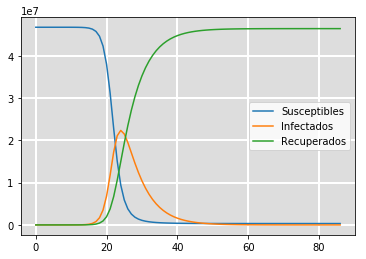

In [343]:
#Datos de contagiados en España, población y definición del período
data, N, t = data_modelo_contagios(joined_data, 'Spain' )
#Condiciones iniciales de infectados y recuperados
I0, R0 = 1, 0
#Todos los demás son susceptibles de contagiarse inicialmente
S0 = N - I0 
#Tasa de transmisión
beta = 1     #dato teórico
#Tasa de recuperación
gamma = 0.2  #dato teórico 

#Obtenemos curva sin ajustar
S1, I1, R1 = sol_edo(S0, I0, R0, t, N, beta, gamma )

#Graficamos para observar I, S, R
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
plt.plot(t,S1, label = 'Susceptibles' )
plt.plot(t, I1, label = 'Infectados')
plt.plot(t, R1, label = 'Recuperados')
ax.legend()
ax.grid(b=True, which='major', c='w', lw=2, ls='-')


In [344]:
#Ahora ajustaremos a los datos de España
casos_diarios = data.diff(1).fillna(0)  #Contagios diarios
#Ajustamos a los datos para obtener beta y gamma
beta_opt, gamma_opt = opt_param(S0, I0, R0, t, N, casos_diarios)
print(beta_opt)
print(gamma_opt)

9.067265154173263
8.895736386199708


In [345]:
#Finalmente resolvemos la EDO con los parámetros de beta y gamma encontrados
Sopt, Iopt, Ropt = sol_edo(S0,I0,R0,t,N,beta_opt,gamma_opt)

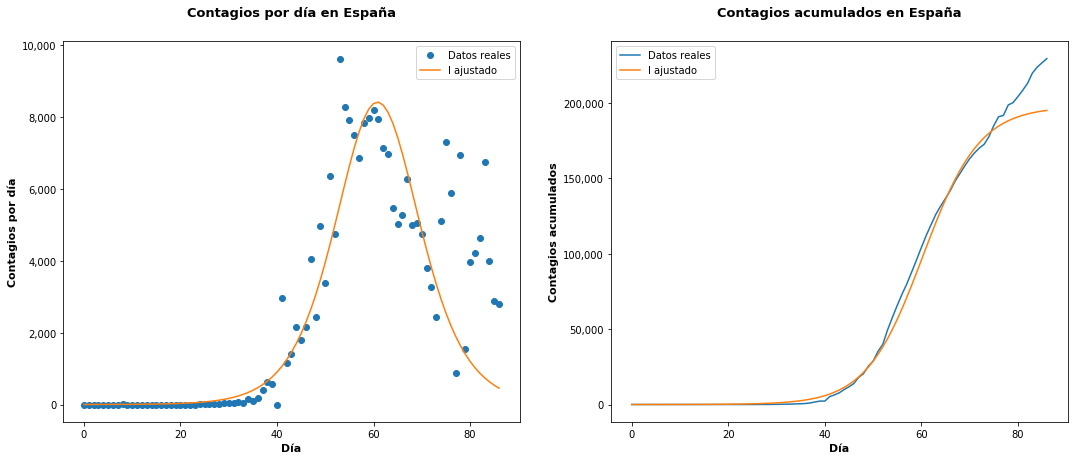

In [346]:
#Graficamos
Iopt_plot(t, casos_diarios, Iopt, data, 'España')

Se observa que la curva se ajusta relativamente bien a los datos, al menos antes del rebrote. También se debe tener en consideración 
que no hay información sobre qué tipo de medidas se han tomado en el país.

In [347]:
#Indicador de desempeño
from sklearn.metrics import r2_score
score_r2 = r2_score(casos_diarios, Iopt)
score_r2

0.7101550031306987

In [348]:
list(zip(Iopt,casos_diarios))

[(1.0, 0.0),
 (1.1871169578985707, 0.0),
 (1.4092437216341522, 0.0),
 (1.672929461965769, 0.0),
 (1.9859479863949843, 0.0),
 (2.3575265411813624, 0.0),
 (2.798617236970655, 0.0),
 (3.322219143995681, 0.0),
 (3.9437602472956, 1.0),
 (4.6815505195060005, 0.0),
 (5.557319159972787, 0.0),
 (6.59685153781237, 0.0),
 (7.830744078297186, 0.0),
 (9.29529882117237, 0.0),
 (11.033582953166963, 0.0),
 (13.096683304227273, 0.0),
 (15.545190922945668, 0.0),
 (18.450956862481316, 0.0),
 (21.899167263344758, 0.0),
 (25.99079369910436, 0.0),
 (30.845483720582006, 0.0),
 (36.604966511855196, 0.0),
 (43.43705960807208, 0.0),
 (51.5403745206539, 0.0),
 (61.14983147335293, 4.0),
 (72.54310577648742, 7.0),
 (86.04814098068461, 2.0),
 (102.05187037751803, 17.0),
 (121.0102966607652, 13.0),
 (143.46007486441113, 39.0),
 (170.0317287549431, 36.0),
 (201.46459913716217, 45.0),
 (238.6235611859875, 57.0),
 (282.51744964864315, 37.0),
 (334.31897701814404, 141.0),
 (395.3857001555218, 100.0),
 (467.2812630292328

El período para el cual se pide estimar la evolución de la enfermedad es entre 2020-04-15 y 2020-05-14, veremos qué sucederá en ese espacio de tiempo de acuerdo a nuestro modelo.

In [349]:
t_completo, dates_completo, t_forecast, dates_forecast, Iopt_for = forecast(S0, I0, R0, N, beta_opt, gamma_opt, joined_data,
                                                                        'Spain', '2020-04-15', '2020-05-14')

(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

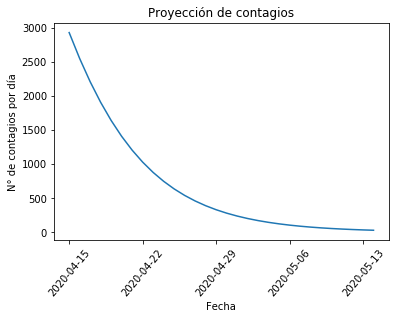

In [350]:
plt.title('Proyección de contagios')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for[-delta_forecast:])
plt.xticks(rotation=50) 

(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

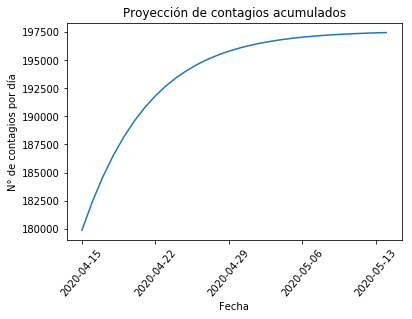

In [351]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for_acc[-delta_forecast:])
plt.xticks(rotation=50) 


(array([737462., 737476., 737490., 737504., 737518., 737532., 737546.,
        737560.]), <a list of 8 Text xticklabel objects>)

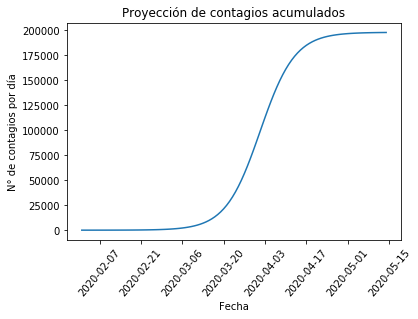

In [352]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_completo, Iopt_for_acc)
plt.xticks(rotation=50) 


In [353]:
#del N, t, data, S0, I0, R0, gamma_opt, beta_opt, casos_diarios, Iopt, t_completo, dates_completo, t_forecast, dates_forecast, Iopt_for
#del t_completo, dates_completo, t_forecast, dates_forecast, Iopt_for

Veremos el caso de Chile

In [354]:
#Chile
data, N, t = data_modelo_contagios(joined_data, 'Chile' )
#Condiciones iniciales de infectados y recuperados
I0, R0 = 1, 0
#Todos los demás son susceptibles de contagiarse inicialmente
S0 = N - I0 
#Tasa de transmisión
beta = 1     #dato teórico
#Tasa de recuperación
gamma = 0.2  #dato teórico 

#Ajustamos modelo a los datos
casos_diarios = data.diff(1).fillna(0)  #Contagios diarios
#Ajustamos a los datos para obtener beta y gamma
beta_opt, gamma_opt = opt_param(S0, I0, R0, t, N, casos_diarios)
print(beta_opt)
print(gamma_opt)

22.85977852834895
22.689133114204097


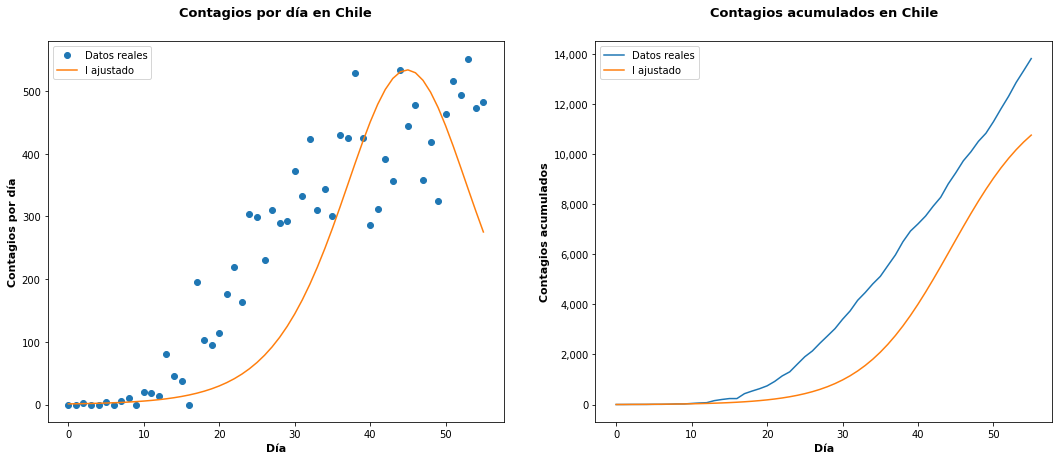

In [355]:
#Resolvemos la EDO con los parámetros de beta y gamma encontrados
Sopt, Iopt, Ropt = sol_edo(S0,I0,R0,t,N,beta_opt,gamma_opt)
#Graficamos
Iopt_plot(t, casos_diarios, Iopt, data, 'Chile')

In [356]:
#Predicción
t_completo, dates_completo, t_forecast, dates_forecast, Iopt_for = forecast(S0, I0, R0, N, beta_opt, gamma_opt, joined_data,'Chile', '2020-04-15', '2020-05-14')


(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

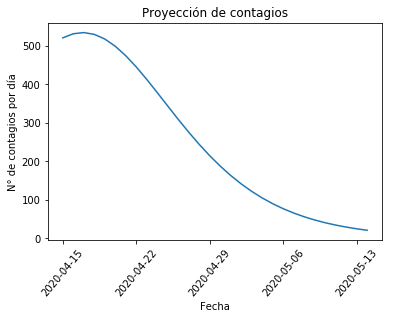

In [357]:
plt.title('Proyección de contagios')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for[-delta_forecast:])
plt.xticks(rotation=50) 

(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

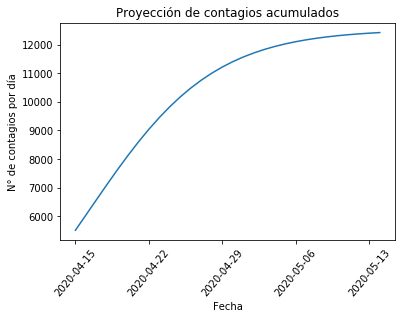

In [358]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for_acc[-delta_forecast:])
plt.xticks(rotation=50) 

(array([737486., 737500., 737514., 737528., 737542., 737556.]),
 <a list of 6 Text xticklabel objects>)

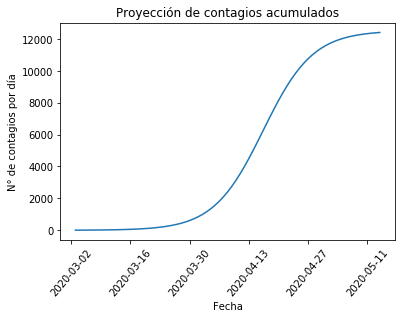

In [361]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_completo, Iopt_for_acc)
plt.xticks(rotation=50) 


Según el modelo la predicción para Chile es que la curva comenzaría a aplanarse a mediados de mayo, pero los hechos muestran que esto no ha sucedido. Hay varios factores que pueden tener relación con esto. Por un lado el período de tiempo considerado puede no ser el suficiente para hacer una predicción más acuciosa. La situación actual también puede tener relación con el relajo de medidas y el consecuente rebrote.

Caso de Francia

9.836692215264097
9.703273890151305


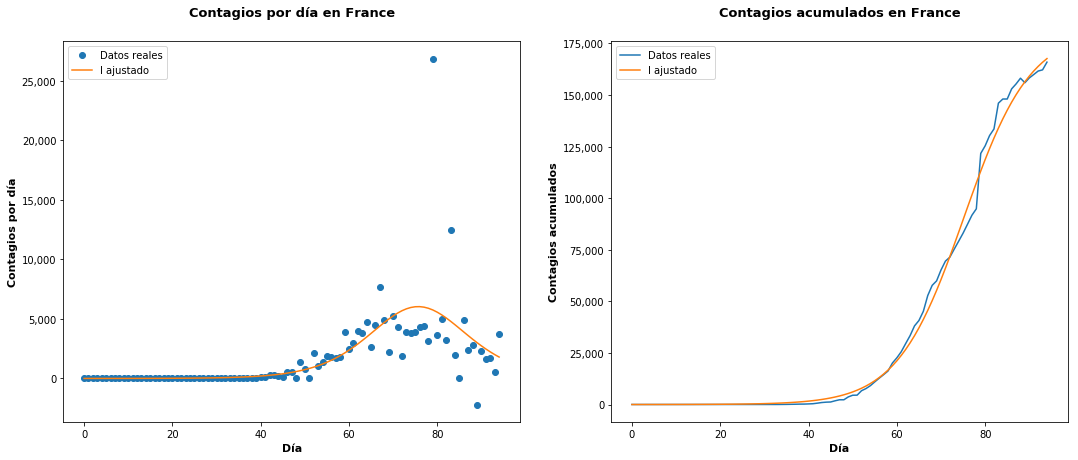

In [379]:
#China
data, N, t = data_modelo_contagios(joined_data, 'France' )
#Condiciones iniciales de infectados y recuperados
I0, R0 = 1, 0
#Todos los demás son susceptibles de contagiarse inicialmente
S0 = N - I0 
#Tasa de transmisión
beta = 1     #dato teórico
#Tasa de recuperación
gamma = 0.2  #dato teórico 

#Ajustamos modelo a los datos
casos_diarios = data.diff(1).fillna(0)  #Contagios diarios
#Ajustamos a los datos para obtener beta y gamma
beta_opt, gamma_opt = opt_param(S0, I0, R0, t, N, casos_diarios)
print(beta_opt)
print(gamma_opt)

#Resolvemos la EDO con los parámetros de beta y gamma encontrados
Sopt, Iopt, Ropt = sol_edo(S0,I0,R0,t,N,beta_opt,gamma_opt)
#Graficamos
Iopt_plot(t, casos_diarios, Iopt, data, 'France')



In [380]:
#R2 score
#from sklearn.metrics import r2_score
score_r2 = r2_score(casos_diarios, Iopt)
score_r2

0.3988139017639729

In [381]:
#Predicción
t_completo, dates_completo, t_forecast, dates_forecast, Iopt_for = forecast(S0, I0, R0, N, beta_opt, gamma_opt, joined_data,'France', '2020-04-15', '2020-05-14')


(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

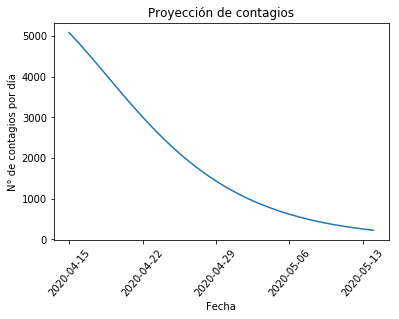

In [382]:
plt.title('Proyección de contagios')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for[-delta_forecast:])
plt.xticks(rotation=50) 



(array([737530., 737537., 737544., 737551., 737558.]),
 <a list of 5 Text xticklabel objects>)

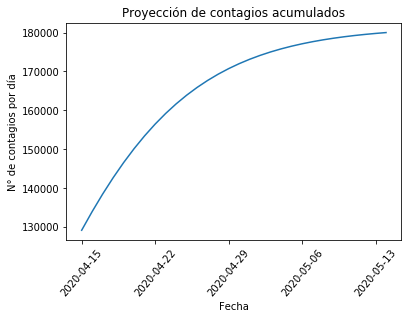

In [383]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_forecast, Iopt_for_acc[-delta_forecast:])
plt.xticks(rotation=50) 

(array([737445., 737459., 737473., 737487., 737501., 737515., 737529.,
        737543., 737557.]), <a list of 9 Text xticklabel objects>)

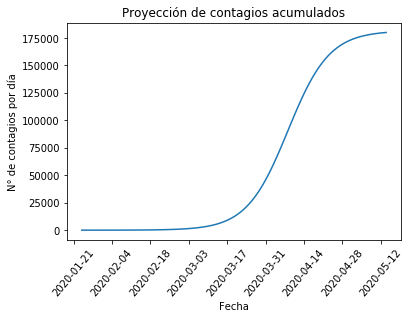

In [384]:
#Proyección de contagios acumulados
Iopt_for_acc = np.cumsum(Iopt_for)
plt.title('Proyección de contagios acumulados')
plt.xlabel('Fecha')
plt.ylabel('N° de contagios por día')
plt.plot(dates_completo, Iopt_for_acc)
plt.xticks(rotation=50) 

Se observa que en algunos casos el modelo SIR muestra buen desempeño y es un buen estimador de cómo evolucionará la enfermedad, sin embargo, es bastante sensible al país que se esté analizando y tendrá desempeños variables. El siguiente paso sería probar otras opciones como usar un modelo ARIMA o algún modelo logístico.